Линейная классификация

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.exceptions import ConvergenceWarning

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


In [3]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

Смотрим на SVM, LR (опорные вектора, логистическая регрессия)

In [4]:
X, Y = make_classification(
    n_samples=10_000, n_features=10, n_informative=5, n_redundant=5,
random_state=42)

In [5]:
#ф-ция для подсчета AUC-PRC
def auc_pr(y_test, y_pred):
    precision, recall, th = precision_recall_curve(y_test, y_pred)
    return auc(recall, precision)

In [6]:
scl = StandardScaler()
X = scl.fit_transform(X)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

x_train_1, x_val, y_train_1, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [8]:
def c_best_selection(C_set, clf, x_train, y_train, x_val, y_val):
    auc_p_r = 0
    C = 1.0

    for C_i in C_set:
        clf.C = C_i
        clf.fit(x_train, y_train)
        a_x = clf.predict(x_val)

        precision, recall, th = precision_recall_curve(y_val, a_x)

        auc_precision_recall = auc(recall, precision)

        if auc_precision_recall > auc_p_r:
            auc_p_r = auc_precision_recall
            C = C_i
    print("Подобранный параметр C:", C)
    return C       

In [9]:
best_C_linearSV = c_best_selection(np.arange(0.001, 100, 1), LinearSVC(), x_train_1, y_train_1, x_val, y_val)

Подобранный параметр C: 49.00099999999999


✅ На тестовой части постройте ROC и PR кривые, а также посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора (который на каждом объекте выдаёт один из двух классов с равными вероятностями).

произведем классификаицю методов опорных векторов.

In [10]:
clf = LinearSVC()
clf.c = best_C_linearSV
clf.fit(x_train, y_train)
a_x = clf.predict(x_test)

In [11]:
precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

In [12]:
print("AUC_PR: %0.5f" % auc(recall, precision))
print("AUC_ROC: %0.5f" % auc(fpr, tpr))

AUC_PR: 0.83139
AUC_ROC: 0.77167


<function matplotlib.pyplot.show(close=None, block=None)>

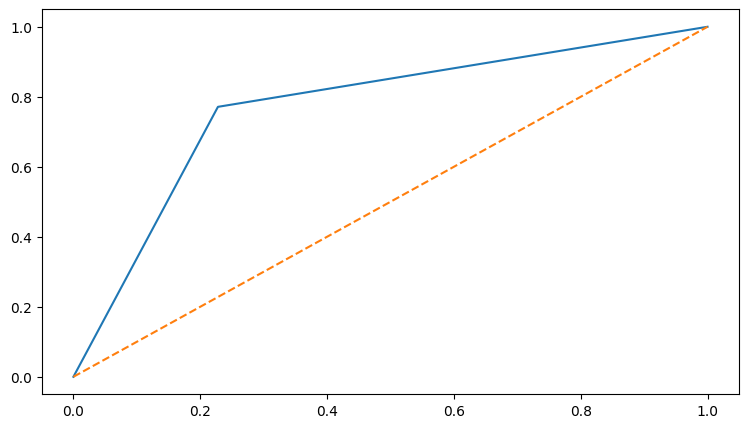

In [13]:
plt.figure(figsize=(9,5))

plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1], [0,1], linestyle='--')

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

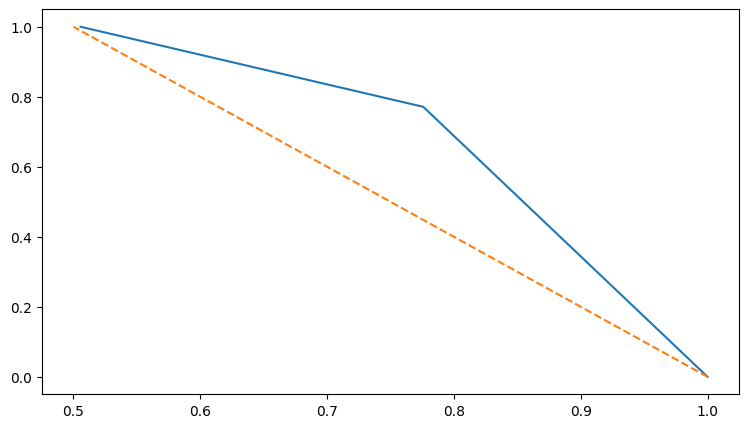

In [14]:
plt.figure(figsize=(9,5))

plt.plot(precision, recall, label="PR")
plt.plot([1,0.5], [0,1], linestyle='--')

plt.show

Вывод: кривые лучше, чем для случайного классификатора.

Тоже самое для логиситической регрессии:

In [15]:
best_C_LR = c_best_selection(np.arange(0.001, 100, 1), LogisticRegression(), x_train_1, y_train_1, x_val, y_val)

Подобранный параметр C: 1.001


In [16]:
clf = LogisticRegression()
clf.c = best_C_LR
clf.fit(x_train, y_train)
a_x = clf.predict(x_test)

In [17]:
precision, recall, th_pr = precision_recall_curve(y_test, a_x)
fpr, tpr, th_roc = roc_curve(y_test, a_x)

In [18]:
print("AUC_PR: %0.5f" % auc(recall, precision))
print("AUC_ROC: %0.5f" % auc(fpr, tpr))

AUC_PR: 0.83116
AUC_ROC: 0.77134


AUC_PR: 0.83139
AUC_ROC: 0.77167


ВЫвод: метод опорных векторов отработал чуть лучше.

# 📌 Работаем с признаками


Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

In [19]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

In [20]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [21]:
df.shape

(41188, 21)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [23]:
df['y'].value_counts()

no     36548
yes     4640
Name: y, dtype: int64

In [24]:
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1

столбец duration сильно влияет на целевую, поэтому удаляем

In [25]:
df.drop(columns='duration', axis=1, inplace=True)

категориальные и вещественные

In [26]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [28]:
#для кодирования категориальных признаков используем OrdinalEncoder
enc = OrdinalEncoder()

In [29]:
data = ColumnTransformer([
    ('cat', enc, cat),
    ('num', StandardScaler(), num)
])

clf = Pipeline(steps=[
    ('enc_and_st_scaler', data),
    ('classifier', LogisticRegression())
])

In [30]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='y'), 
                                                    df['y'], test_size=0.3, 
                                                    random_state=777, stratify=df['y'])
y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [31]:
start_time = time.time()
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Время на обучение OrdinalEncoder:', time.time() - start_time)
print('AUC_PR на OrdinalEncoder: %0.5f' % auc_pr(y_test, y_pred))
print('Кол-во столбцов', data.fit_transform(x_train).shape[1])

Время на обучение OrdinalEncoder: 0.7715961933135986
AUC_PR на OrdinalEncoder: 0.95330
Кол-во столбцов 19


In [32]:
model

Pipeline(steps=[('enc_and_st_scaler',
                 ColumnTransformer(transformers=[('cat', OrdinalEncoder(),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome']),
                                                 ('num', StandardScaler(),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.conf.idx',
                                                   'cons.price.idx',
                                                   'euribor3m',
                                                   'nr.employed'])])),
                ('classifier', LogisticRegression())])

In [33]:
enc = OneHotEncoder(handle_unknown='ignore')

date = ColumnTransformer([
    ('cat', enc, cat),
    ('num', StandardScaler(), num)
])

clf = Pipeline(steps=[
    ('enc_and_st_scaler', date),
    ('classifier', LogisticRegression())
])

In [34]:
start_time = time.time()
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Время на обучение OHE:', time.time() - start_time)
print('AUC_PR на OHE: %0.5f' % auc_pr(y_test, y_pred))
print('Кол-во столбцов', date.fit_transform(x_train).shape[1])

Время на обучение OHE: 1.318964958190918
AUC_PR на OHE: 0.95339
Кол-во столбцов 62


OHE работает дольше OE, но одинаковое качество

Как можно было заменить, one-hot-кодирование может сильно увеличивать количество признаков, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — mean-target encoding (для простоты будем называть это счётчиками). Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории. Метод предполагает кодирование категорий средним арифметическим от суммы целевых меток
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$



In [35]:
data = ColumnTransformer([
    ('cat', 'passthrough', cat),
    ('num', StandardScaler(), num)
])

clf = Pipeline(steps=[
    ('enc_and_st_scaler', data),
    ('classifier', LogisticRegression())
])

In [36]:
start_time = time.time()

for col in cat:
    for categ in list(pd.unique(x_train[col])):
        g_train = x_train[(x_train[col] == categ) & (y_train == 1)].shape[0] / x_train[x_train[col] == categ].shape[0]
        x_train.loc[x_train[col] == categ, col] = g_train
        
        
        g_test = x_test[(x_test[col] == categ) & (y_test == 1)].shape[0] / x_test[x_test[col] == categ].shape[0]
        x_test.loc[x_test[col] == categ, col] = g_test 

#обучение, тестировние        
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding = %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', x_train.shape[1])

Время на обучение модели: 1.8725790977478027
AUC-PR при mean-target encoding = 0.95312
Кол-во столбцов  19


In [37]:
start_time = time.time()
for col in cat:
    #добавим шума к категориальным признакам
    x_train[col] += np.random.rand(x_train.shape[0]) * np.sign(np.random.rand(x_train.shape[0]) - 0.5) / 10
    x_test[col] += np.random.rand(x_test.shape[0]) * np.sign(np.random.rand(x_test.shape[0]) - 0.5) / 10

clf = LogisticRegression()
model = clf.fit(x_train, y_train)
y_pred = model.predict(x_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при mean-target encoding и шуме= %.5f" %  auc_pr(y_test, y_pred))
print('Кол-во столбцов ', x_train.shape[1])

Время на обучение модели: 0.8372898101806641
AUC-PR при mean-target encoding и шуме= 0.95217
Кол-во столбцов  19


Качество упало, так как для кодирования категориальных признаков использовались зависмости  с целевой переменной, для этого добавляется шум и сглаживание 

✅ Добавьте сглаживание, а затем повторите эксперименты.

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$

In [38]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [39]:
#вещественные признаки также отмасштабируем, категориальные отмасштабируем отдельно
data = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

In [40]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 1.7583632469177246
AUC-PR при global mean = 0.95536


Качество улучшилось

✅ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [41]:
#разделим выборку
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'y'), 
                                                    df['y'], test_size=0.3, random_state=777, stratify = df['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [42]:
print('Кол-во уникальных возрастов', df['age'].nunique())

Кол-во уникальных возрастов 78


In [43]:
#теперь возраст категориальная переменная
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [44]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 3.0884170532226562
AUC-PR при global mean = 0.96042


✅ Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [45]:
X = df

In [46]:
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1


In [47]:
month = X['month'].unique().tolist()
day_of_week = X['day_of_week'].unique().tolist()

In [48]:
month

['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr', 'sep']

In [49]:
day_of_week

['mon', 'tue', 'wed', 'thu', 'fri']

In [50]:
month_dict = {'may': 5, 'jun': 6, 'jul': 7,
             'aug': 8, 'oct': 10, 'nov': 11,
             'dec': 12, 'mar': 3, 'apr': 4, 
             'sep': 9}

day_dict = {'mon': 1, 'tue': 2,
            'wed': 3, 'thu': 4,
            'fri': 5}

In [51]:
X = X.replace({"month":month_dict})
X = X.replace({"day_of_week":day_dict})

In [52]:
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
1,57,services,married,high.school,unknown,no,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
2,37,services,married,high.school,no,yes,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
3,40,admin.,married,basic.6y,no,no,no,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
4,56,services,married,high.school,no,no,yes,telephone,5,1,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,11,5,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0
41184,46,blue-collar,married,professional.course,no,no,no,cellular,11,5,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41185,56,retired,married,university.degree,no,yes,no,cellular,11,5,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,1
41186,44,technician,married,professional.course,no,no,no,cellular,11,5,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,0


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns = 'y'), 
                                                    X['y'], test_size=0.3, random_state=777, stratify = X['y'])

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [54]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'poutcome', 'age']

num = ['campaign', 'pdays', 'previous', 'emp.var.rate', 'month', 'day_of_week',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [55]:
data = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])


#создадим пайплайн с LogisticRegression регрессией и кодировщиком данных 
clf = Pipeline(steps=[
                   ('enc_and_st_scaler', data),
                   ('classifier', LogisticRegression())
                   ])

In [56]:
start_time = time.time()

C = 100

for col in cat:
    for categ in list(pd.unique(X_train[col])):
        g_new = X_train[(X_train[col] == categ) & (y_train == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y_train[y_train == 1].shape[0] / X_train.shape[0])
        g_new /= X_train[X_train[col] == categ].shape[0] + C
        X_train.loc[X_train[col] == categ, col] = g_new

        g_new_test = X_test[(X_test[col] == categ) & (y_test == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new_test += C * (y_test[y_test == 1].shape[0] / y_train.shape[0])
        g_new_test /= C + X_test[X_test[col] == categ].shape[0]
        X_test.loc[X_test[col] == categ, col] = g_new_test 
        
model = clf.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Время на обучение модели:', time.time() - start_time)
print("AUC-PR при global mean = %.5f" %  auc_pr(y_test, y_pred))

Время на обучение модели: 2.3713393211364746
AUC-PR при global mean = 0.95855


"Возраст" - категориальный признак:

Время на обучение модели: 1.883796215057373

AUC-PR при global mean = 0.96042


Первоначальный вариант

Время на обучение модели: 1.5655951499938965

AUC-PR при global mean = 0.95536

Вывод: Качество модели улучшилось по сравнению с первоначальным вариантом, но стало хуже после переделывания столбцов "Месяц" и "День недели". Но при этом вемя уменьшилось. Значит есть смысл не напрямую кодировать данные, а вникать в суть признаков.

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тем же данным про банковский телефонный маркетинг.

In [57]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [58]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [59]:
#для красивого вывода названий столбцов
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask, drop_first=True)

In [60]:
X_train.shape

(28831, 52)

In [61]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)

auc_pr_lr_ohe = auc_pr(y_test, a_x)

In [62]:
print("AUC_PR = %.5f" % auc_pr_lr_ohe)

AUC_PR = 0.95224


Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отборам признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.





In [63]:

indeces = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

Отсортирвали веса признаков и взяли максимальные 40

In [64]:
start_time = time.time()

x_train = X_train.iloc[:, indeces.values]
x_test = X_test.iloc[:, indeces.values]

clf_1 = LogisticRegression()
clf_1.fit(x_train, y_train)
a_x = clf_1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время на обучение модели:', time.time() - start_time)
print("AUC_PR = %.5f" % auc_pr_lr_fourty)

Время на обучение модели: 0.8860714435577393
AUC_PR = 0.95190


Качество упало

Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

In [65]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#разделили выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [66]:
#вещественные признаки отмасштабируем с помощью StandardScaler, категориальные пока не трогаем
date = ColumnTransformer([
                     ('cat', 'passthrough', cat),
                     ('num', StandardScaler(), num)
                     ])

X_train = pd.DataFrame(date.fit_transform(X_train))
X_test = pd.DataFrame(date.transform(X_test))

In [67]:
#кодируем категориальные признаки
cat_mask = X_train.select_dtypes(include=['object']).columns
cat_mask = X_test.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(data=X_train, columns=X_train.iloc[:, 0:10].columns, drop_first=True)
X_test = pd.get_dummies(data=X_test, columns=X_test.iloc[:, 0:10].columns, drop_first=True)

In [68]:
X_train.columns = X_train.columns.astype(str)

In [69]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [70]:
start_time = time.time()

indices = pd.DataFrame(clf.coef_[0], [*range(52)]).sort_values(by=0).tail(40).index

x_train = X_train.iloc[:, indices.values]
x_test = X_test.iloc[:, indices.values]

x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)
clf1 = LogisticRegression()
clf1.fit(x_train, y_train)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время обучения модели', time.time()-start_time)
print("AUC_PR = %.5f" % auc_pr_lr_fourty)
print('indices =', indices)
indeces_1 = indices.tolist()

Время обучения модели 0.7904233932495117
AUC_PR = 0.95215
indices = Int64Index([16, 26, 13,  5, 47, 48, 45, 20, 29, 18,  0, 28, 11, 17, 24, 33, 25,
            10, 12,  3, 39, 31, 14, 35, 32, 34, 27, 15,  1, 44, 19,  2, 46,  9,
            30, 42, 43, 40, 36,  4],
           dtype='int64')


### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.




✅ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.

In [76]:
from math import sqrt

import itertools

In [77]:
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])


#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

In [78]:
cat = ['job', 'marital', 'education', 'default', 'housing',
            'loan', 'contact', 'month', 'day_of_week', 'poutcome']

num = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
          'cons.conf.idx', 'cons.price.idx', 'euribor3m', 'nr.employed']

In [79]:
#кодируем категориальные признаки с помощью метода счетчиков
C = 100

for col in cat:
    for categ in list(pd.unique(X[col])):
        g_new = X[(X[col] == categ) & (y == 1)].shape[0]
        #добавляем долю объектов положительного класса
        g_new += C * (y[y == 1].shape[0] / X.shape[0])
        g_new /= X[X[col] == categ].shape[0] + C
        X.loc[X[col] == categ, col] = g_new

In [80]:
#отмаcштабировали категориальные и числовые признаки
date = ColumnTransformer([
                     ('cat', StandardScaler(), cat),
                     ('num', StandardScaler(), num)
                     ])
X = pd.DataFrame(date.fit_transform(X) ,columns=X.columns)

In [81]:
start_time = time.time()

#считаем t-статистику для каждого признака
t_state = {}

n_p = len(y[y == 1])
n_m = len(y[y == 0])

for col in X.columns:
    mu = np.abs(X.loc[df['y']==1, col].mean() - X.loc[df['y']==0, col].mean())
    sigma_p = X.loc[df['y']==1, col].std()**2
    sigma_m = X.loc[df['y']==0, col].std()**2
    t_state[col] = mu/sqrt((sigma_p*n_p + sigma_m*n_m)/(n_p + n_m))

#сортируем по убыванию 
t_state = dict(sorted(t_state.items(), key=lambda x: x[1], reverse=True))

#оставляем наибольшие 40
indeces_t = list(dict(itertools.islice(t_state.items(),40)).keys())

end_time = time.time() - start_time

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=777, stratify=y)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

In [83]:
x_train = X_train[indeces_t]
x_test = X_test[indeces_t]

x_train.columns = x_train.columns.astype(str)
x_test.columns = x_test.columns.astype(str)

In [84]:
#обучаем модель
start_time = time.time()

clf = LogisticRegression()
clf.fit(x_train, y_train)
a_x = clf.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print('Время обучения модели', time.time()-start_time + end_time)
print("AUC_PR = %.5f" % auc_pr_lr_fourty)

Время обучения модели 0.5236468315124512
AUC_PR = 0.95378


Качество улучшилось, время значительно уменьшилось

### Методы-обёртки


Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).


✅ Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [92]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

'''
#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
'''

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕЛВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
#y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
#y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
#cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
#X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
#X_val = pd.DataFrame(scaler.transform(X_val))

X_train.columns = columns_
X_test.columns = columns_
#X_val.columns = columns_

In [93]:
clf = LogisticRegression()

In [97]:
clf.fit(X_train, y_train)
a_x = clf.predict(X_test)
auc_pr_0 = auc_pr(y_test, a_x)

while len(X_train.columns) > 40:
    auc_pr_0 = 0
    for col in X_train.columns:
        x_tr_cycle = X_train.drop(col, axis=1)
        x_test_cycle = X_test.drop(col, axis=1)

        clf.fit(x_tr_cycle, y_train)
        a_x_cycle = clf.predict(x_test_cycle)
        auc_pr_cycle = auc_pr(y_test, a_x_cycle)

        if auc_pr_cycle > auc_pr_0:
            auc_pr_0 = auc_pr_cycle
            column = col
    
    X_train.drop(column, axis=1, inplace=True)
    X_test.drop(column, axis=1, inplace=True)

In [98]:
len(X_train.columns)

40

In [96]:
auc_pr_0

0.9545555981537819

In [99]:
auc_pr_0

0.9545662302392459

In [105]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕЛВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train1.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train1 = pd.get_dummies(X_train1, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train1.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train1 = pd.DataFrame(scaler.fit_transform(X_train1))
X_test = pd.DataFrame(scaler.transform(X_test))
X_val = pd.DataFrame(scaler.transform(X_val))

X_train1.columns = columns_
X_test.columns = columns_
X_val.columns = columns_

In [108]:
start_time = time.time()

best_to_drop = 0
best_auc = 0.5
X = X_train1
val = X_val

for col in X.columns:
    x_train = X.drop(col, axis=1)

    clas = LogisticRegression()
    clas.fit(x_train, y_train1)

    x_val = val.drop(col, axis=1)

    predict = clas.predict(x_val)

    auc_pr_new = auc_pr(y_val, predict)

    if auc_pr_new > best_auc:
        best_auc = auc_pr_new
        best_to_drop = col

        X_train1 = X_train1.drop(columns=best_to_drop, axis=1)
        X_val = X_val.drop(columns=best_to_drop, axis=1)
        X_test = X_test.drop(columns=best_to_drop, axis=1)

y_train1 = y_train1.reset_index().drop(columns='index')['y']
y_test = y_test.reset_index().drop(columns='index')['y']
X_train1.columns = np.arange(X_train1.shape[1])
X_test.columns = np.arange(X_test.shape[1])

t = np.empty(X_train1.shape[1])

for j in range(X_train1.shape[1]):
    t[j] = (abs(X_train1[j][y_train1==1].mean() - X_train1[j][y_train1==0].mean())/
            sqrt((X_train1[j][y_train1==1].shape[0]*(X_train1[j][y_train1==1].std()**2)+
                  X_train1[j][y_train1==0].shape[0]*(X_train1[j][y_train1==0].std()**2)) /
                  X_train1[j][y_train1==1].shape[0]+X_train1[j][y_train1==0].shape[0]))
    
indeces = pd.DataFrame(t, [*range(48)]).sort_values(by=0).tail(40).index

x_train = X_train1.iloc[:, indeces.values]
x_test = X_test.iloc[:, indeces.values]

clf1 = LogisticRegression()
clf1.fit(x_train, y_train1)
a_x = clf1.predict(x_test)

auc_pr_lr_fourty = auc_pr(y_test, a_x)

print("время", time.time() - start_time)
print(auc_pr_lr_fourty)

время 27.264808177947998
0.953728035178733


✅ Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте добавлять по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. 

In [125]:
#ПОДГРУЗКА ДАННЫХ
df = pd.read_csv('bank-additional-full.csv', sep=';')

#удалили целевой столбец и неинформативный признак
X = df.drop(columns=['duration', 'y'])

#обработали столбец таргета
df.loc[df['y'] == 'yes', 'y'] = 0
df.loc[df['y'] == 'no', 'y'] = 1
y = df['y']

#обучающая и тестовая
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

'''
#валидационная
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
'''

#ПРЕОБРАЗОВАНИЕ ЦЕЛЕЛВОЙ ПЕРЕМЕННОЙ 
y_train = y_train.astype('int')
#y_train1 = y_train1.astype('int')
y_test = y_test.astype('int')
#y_val = y_val.astype('int')

#КОДИРОВАНИЕ ДАННЫХ
#закодировали категории
cat_mask1 = X_train.select_dtypes(include=['object']).columns
cat_mask2 = X_test.select_dtypes(include=['object']).columns
#cat_mask3 = X_val.select_dtypes(include=['object']).columns

#drop_first = True даст k-1 столбцов для столбца с k категориями -> избежим попадения в дамми-трэп
X_train = pd.get_dummies(X_train, columns = cat_mask1, drop_first=True)
X_test = pd.get_dummies(X_test, columns = cat_mask2, drop_first=True)
#X_val = pd.get_dummies(X_val, columns = cat_mask3, drop_first=True)
columns_ = X_train.columns

#отмасштабируем все!
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))
#X_val = pd.DataFrame(scaler.transform(X_val))

X_train.columns = columns_
X_test.columns = columns_
#X_val.columns = columns_

X_train_new = pd.DataFrame()
X_test_new = pd.DataFrame()

In [126]:
while len(X_train_new.columns) < 40:
    auc_pr_0 = 0
    for col in X_train.columns:
        X_train_new[col] = X_train[col]
        X_test_new[col] = X_test[col]

        clf.fit(X_train_new, y_train)
        a_x_cycle = clf.predict(X_test_new)
        auc_pr_cycle = auc_pr(y_test, a_x_cycle)

        X_train_new.drop(col, axis=1, inplace=True)
        X_test_new.drop(col, axis=1, inplace=True)

        if auc_pr_cycle > auc_pr_0:
            auc_pr_0 = auc_pr_cycle
            column = col
    
    X_train_new[column] = X_train[column]
    X_test_new[column] = X_test[column]
    X_train.drop(column, axis=1, inplace=True)

In [127]:
len(X_train_new.columns)

40

In [128]:
auc_pr_0

0.9537494506084306